In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from catboost import Pool, CatBoostClassifier, cv
pd.options.display.max_columns
pd.set_option('display.max_columns', None)

# Data Prep

In [2]:
X_train = pd.read_csv('https://raw.githubusercontent.com/mkleinbort/Kaggle-COMPAS/main/train/X_train.csv', index_col='id')
y_train = pd.read_csv('https://raw.githubusercontent.com/mkleinbort/Kaggle-COMPAS/main/train/y_train.csv', squeeze=True)
X_test = pd.read_csv ('https://raw.githubusercontent.com/mkleinbort/Kaggle-COMPAS/main/test/X_test.csv')
y_test = np.full(len(X_test), np.nan)

In [3]:
df = pd.concat([X_train, X_test])

df = df.drop(['v_screening_date'], axis=1) # duplicate of 'screening_date'
df = df.drop(['v_type_of_assessment'], axis=1) # duplicate of 'type_of_assessment'
df = df.drop(['type_of_assessment'], axis=1) # 0 variance

df['target'] = y_train.to_list() + list(y_test) # set target row-wise (ignoring indices)
# df['target'] = 0

In [4]:
# Engineer a new targets 
df['target_int'] = df['target'].replace({'No-Recidivism': 0, 'Non-Violent': 1, 'Violent': 2}) # so we can do regression
df['target_bool'] = df['target'].replace({'No-Recidivism': 0, 'Non-Violent': 1, 'Violent': 1}) # 0 - no-rec, 1 - rec
target_cols = ['target', 'target_int', 'target_bool']

In [5]:
# Engineer new date based features

"""
Custody: when someone is kept in prison until they go to court
Screening:  involves  using  a  brief  instrument  to  quickly  capture basic information 
    about a person’s risk to reoffend and is  used  to  determine  if  a  more  comprehensive  assessment
    is  warranted.  In  a  jail  setting,  everyone,  regardless  of  legal  status, should be screened 
    at booking.  Risk  screening  divides  the  jail  population  into  high-,  medium-,  and  low-risk 
    categories,  making  it  possible  to  direct  intervention  resources  first  to  the highest-risk individuals.



- c_arrest_date and c_offense_date are mutually exclusive and one of them is 99.8% likely to be filled
- c_arrest_date and c_are mutually exclusive
- start is number of days between c_jail_in and c_jail_out, maybe worth engineering total hours/minutes between
- screening_date is always filled
"""



days_cols = []

def days_between(d1, d2):
    try:
        try:
            d1 = datetime.strptime(d1, "%Y-%m-%d")
        except ValueError:
            d1 = datetime.strptime(d1, "%Y-%m-%d %H:%M:%S")
            
        try:
            d2 = datetime.strptime(d2, "%Y-%m-%d")
        except ValueError:
            d2 = datetime.strptime(d2, "%Y-%m-%d %H:%M:%S")
        return abs((d2 - d1).days)
    except TypeError as e:
        return None

# mutually exclusive and one of them is always filled
df['c_bad_date'] = df['c_arrest_date'].fillna(df['c_offense_date']).fillna(df['in_custody']).fillna(df['screening_date'])

# how many days in custody
df['custody_days'] = df.apply(lambda x: days_between(x.out_custody, x.in_custody), axis=1)

# how quickly after going into custody did the person get screened (might indicate something?)
df['in_custody_to_screening_days'] = df.apply(lambda x: days_between(x.in_custody, x.screening_date), axis=1)

# questionable col because it is age related... Also corr=1 with age
df['birth_to_bad_days'] = df.apply(lambda x: days_between(x.date_of_birth, x.c_bad_date), axis=1)

# How many days passed until recitivism occcured. Golden feature!
df['days_until_recitivism'] = df.apply(lambda x: days_between(x.c_jail_out, x.r_jail_in), axis=1)

date_cols = [ 
    'c_arrest_date', 
    'c_offense_date',
    'screening_date', 
    'in_custody', 
    'out_custody', 
    'date_of_birth',
    'c_jail_in',
    'c_jail_out',
    'r_jail_in',
    'r_jail_out',

    # engineered
    'c_bad_date'
]

duration_cols = [
    'days_b_screening_arrest',
    'custody_days',
    'in_custody_to_screening_days',
    'birth_to_bad_days',
    'days_until_recitivism',
]

df.head()

,name,first,last,sex,date_of_birth,age,age_group,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_jail_in,c_jail_out,c_offense_date,c_arrest_date,c_charge_degree,c_charge_desc,r_jail_in,r_jail_out,screening_date,in_custody,out_custody,start,id,target,target_int,target_bool,c_bad_date,custody_days,in_custody_to_screening_days,birth_to_bad_days,days_until_recitivism
2677,nicholas staggewise,nicholas,staggewise,Male,1994-02-28,22,Less than 25,Caucasian,0,0,0,2,-1.0,2013-09-23 09:01:58,2013-09-27 03:54:42,NaN,2013-09-23,F,arrest case no charge,NaN,NaN,2013-09-24,2013-09-23,2013-09-27,3,NaN,No-Recidivism,0.0,0.0,2013-09-23,4.0,1.0,7147,NaN
548,newton smith,newton,smith,Male,1995-01-28,21,Less than 25,African-American,0,1,0,1,-1.0,2013-06-16 12:36:42,2013-06-16 07:01:42,2013-06-15,NaN,F,Grand Theft in the 3rd Degree,NaN,NaN,2013-06-17,2013-06-16,2013-06-16,0,NaN,Violent,2.0,1.0,2013-06-15,0.0,1.0,6713,NaN
4483,terrance irvin,terrance,irvin,Male,1984-04-10,32,25 - 45,African-American,0,0,0,6,-1.0,2013-10-11 05:38:14,2013-10-15 07:11:17,2013-10-11,NaN,F,Grand Theft in the 3rd Degree,2013-12-21,2014-02-21,2013-10-12,2013-10-11,2013-10-15,3,NaN,Non-Violent,1.0,1.0,2013-10-11,4.0,1.0,10776,66.0
9476,jaimie peterson,jaimie,peterson,Female,1986-01-02,30,25 - 45,African-American,0,0,0,3,-1.0,2014-01-11 06:56:43,2014-01-12 02:17:00,2014-01-11,NaN,F,Felony Driving While Lic Suspd,NaN,NaN,2014-01-12,2014-01-11,2014-01-12,0,NaN,No-Recidivism,0.0,0.0,2014-01-11,1.0,1.0,10236,NaN
199,ritesh sukhlall,ritesh,sukhlall,Male,1987-05-12,28,25 - 45,Caucasian,0,0,0,2,NaN,NaN,NaN,NaN,2013-03-21,F,arrest case no charge,NaN,NaN,2013-08-29,NaN,NaN,0,NaN,No-Recidivism,0.0,0.0,2013-03-21,NaN,NaN,9445,NaN


In [6]:
# All prior counts
df['all_priors'] = df[[
    'juv_fel_count',
    'juv_misd_count', 
    'juv_other_count',
    'priors_count',
]].sum(axis=1)

In [7]:
# Has recidivism occured?
df['has_r_jail_in'] = df['r_jail_in'].notna()
df['has_r_jail_out'] = df['r_jail_out'].notna()

In [8]:
# fill missing values
df['c_charge_desc'] = df['c_charge_desc'].fillna('missing') 

In [9]:
df.head()

,name,first,last,sex,date_of_birth,age,age_group,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_jail_in,c_jail_out,c_offense_date,c_arrest_date,c_charge_degree,c_charge_desc,r_jail_in,r_jail_out,screening_date,in_custody,out_custody,start,id,target,target_int,target_bool,c_bad_date,custody_days,in_custody_to_screening_days,birth_to_bad_days,days_until_recitivism,all_priors,has_r_jail_in,has_r_jail_out
2677,nicholas staggewise,nicholas,staggewise,Male,1994-02-28,22,Less than 25,Caucasian,0,0,0,2,-1.0,2013-09-23 09:01:58,2013-09-27 03:54:42,NaN,2013-09-23,F,arrest case no charge,NaN,NaN,2013-09-24,2013-09-23,2013-09-27,3,NaN,No-Recidivism,0.0,0.0,2013-09-23,4.0,1.0,7147,NaN,2,False,False
548,newton smith,newton,smith,Male,1995-01-28,21,Less than 25,African-American,0,1,0,1,-1.0,2013-06-16 12:36:42,2013-06-16 07:01:42,2013-06-15,NaN,F,Grand Theft in the 3rd Degree,NaN,NaN,2013-06-17,2013-06-16,2013-06-16,0,NaN,Violent,2.0,1.0,2013-06-15,0.0,1.0,6713,NaN,2,False,False
4483,terrance irvin,terrance,irvin,Male,1984-04-10,32,25 - 45,African-American,0,0,0,6,-1.0,2013-10-11 05:38:14,2013-10-15 07:11:17,2013-10-11,NaN,F,Grand Theft in the 3rd Degree,2013-12-21,2014-02-21,2013-10-12,2013-10-11,2013-10-15,3,NaN,Non-Violent,1.0,1.0,2013-10-11,4.0,1.0,10776,66.0,6,True,True
9476,jaimie peterson,jaimie,peterson,Female,1986-01-02,30,25 - 45,African-American,0,0,0,3,-1.0,2014-01-11 06:56:43,2014-01-12 02:17:00,2014-01-11,NaN,F,Felony Driving While Lic Suspd,NaN,NaN,2014-01-12,2014-01-11,2014-01-12,0,NaN,No-Recidivism,0.0,0.0,2014-01-11,1.0,1.0,10236,NaN,3,False,False
199,ritesh sukhlall,ritesh,sukhlall,Male,1987-05-12,28,25 - 45,Caucasian,0,0,0,2,NaN,NaN,NaN,NaN,2013-03-21,F,arrest case no charge,NaN,NaN,2013-08-29,NaN,NaN,0,NaN,No-Recidivism,0.0,0.0,2013-03-21,NaN,NaN,9445,NaN,2,False,False


In [10]:
##########################################
### Select features to use in modeling ###
##########################################

cols = [
#     'name', useless
#     'first', useless
#     'last', useless
#     'sex', # 0 importance + potential bias
#     'date_of_birth', date
#     'age', # innapropriate bias
#     'age_group', # innapropriate bias
#     'race', # innapropriate bias
#     'juv_fel_count',
#     'juv_misd_count', 
#     'juv_other_count',
#     'priors_count', 
    'days_b_screening_arrest', # + AUC, - fairness
#     'c_jail_in', date
#     'c_jail_out',date
#     'c_offense_date', date
#     'c_arrest_date', date
#     'c_charge_degree',  # 0 importance
#     'c_charge_desc',
#     'r_jail_in', date
#     'r_jail_out', date
#     'screening_date', date
#     'in_custody', date
#     'out_custody', date
    'start', # + AUC, + fairness
#     'target', target
#     'target_int', target
#     'target_bool', target
#     'c_bad_date', date
    'custody_days', # + AOC, + fairness
    'in_custody_to_screening_days', # + AUC, + fairness
#     'birth_to_bad_days', # corr=1 with age
#     'has_r_jail_in', + AUC, - fairness
#     'has_r_jail_out', # corr=1 with r_jail_in
    'days_until_recitivism', # golden feature!
    'all_priors', # the most racist/sexist/ageist feature, but without it it is even more unfair
]

cat_cols = [
#     'sex',  # innapropriate bias
#     'age_group', # innapropriate bias
#     'race', # innapropriate bias
#     'c_charge_degree', # 0 importance
#     'c_charge_desc',
]

In [11]:
# Count missing values
df[cols].isna().sum()/len(df[cols])

days_b_screening_arrest         0.056504
start                           0.000000
custody_days                    0.044065
in_custody_to_screening_days    0.044065
days_until_recitivism           0.855577
all_priors                      0.000000
dtype: float64

<AxesSubplot:>

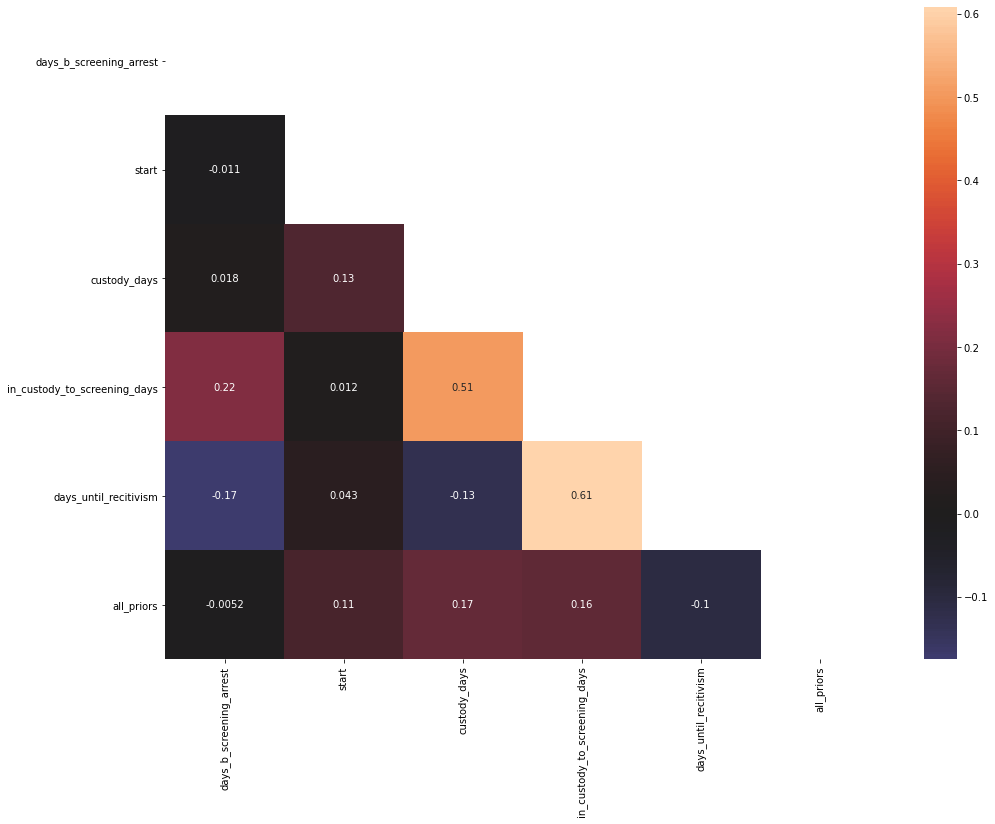

In [12]:
# Numeric correlations across numeric features
f, ax = plt.subplots(figsize=(16, 12))
corr = df[cols].corr()
mask = np.triu(corr)
sns.heatmap(corr.select_dtypes('number'), annot=True, center=0, mask=mask)

In [13]:
df[cols].head()

,days_b_screening_arrest,start,custody_days,in_custody_to_screening_days,days_until_recitivism,all_priors
2677,-1.0,3,4.0,1.0,NaN,2
548,-1.0,0,0.0,1.0,NaN,2
4483,-1.0,3,4.0,1.0,66.0,6
9476,-1.0,0,1.0,1.0,NaN,3
199,NaN,0,NaN,NaN,NaN,2


In [14]:
# df['race'] = df['race'].replace({'Native American': 'Other'})
# df['race'] = df['race'].replace({'Native American': 'Other', 'Asian': 'Other'})
# df['race'] = df['race'].replace({'Native American': 'Other', 'Asian': 'Other', 'Hispanic': 'Other'})
df['race'].value_counts()

African-American    2266
Caucasian           1701
Hispanic             458
Other                280
Asian                 27
Native American       11
Name: race, dtype: int64

In [15]:
df['age'] = df['age_group'] # we don't care about the actual age anyway
df['race_age'] = df['race'] + df['age_group']
df['race_sex'] = df['race'] + df['sex']
df['sex_age'] = df['sex'] + df['age_group']
df['race_sex_age'] = df['race'] + df['sex'] + df['age_group']

In [16]:
races = df.race.unique()
sexes = df.sex.unique()
age_groups = df.age_group.unique()

In [17]:
# df[cols] = df[cols].fillna(0)

In [18]:
# Set hyperparamets
hyperparams = dict(
    iterations=100,
    learning_rate=1,
    depth=3,
    loss_function='MultiClass'
)

In [19]:
df_train = df[df.target.notna()]
df_test = df[df.target.isna()]

In [20]:
from itertools import chain, combinations

def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return list(chain.from_iterable(combinations(s, r) for r in range(len(s)+1)))[1:]

powerset(['race', 'sex', 'age'])

[('race',),
 ('sex',),
 ('age',),
 ('race', 'sex'),
 ('race', 'age'),
 ('sex', 'age'),
 ('race', 'sex', 'age')]

# Cross Validation

In [21]:
from sklearn.metrics import roc_auc_score

def roc_auc_score_calm(y_true, y_score, *, average="macro", sample_weight=None,
                  max_fpr=None, multi_class="raise", labels=None):
    try:
        return roc_auc_score(**locals())
    except ValueError:
        return None

# Try predicting race/sex/age
To see if we can, ideally we shouldn't
Feature importances also will tell us the most racist/sexist/ageist features

Target col: race
ROC-AUC 59.12% (STD: 4.77%)


<AxesSubplot:ylabel='feature'>

Target col: sex
ROC-AUC 59.38% (STD: 2.17%)


<AxesSubplot:ylabel='feature'>

Target col: age_group
ROC-AUC 57.63% (STD: 1.28%)


<AxesSubplot:ylabel='feature'>

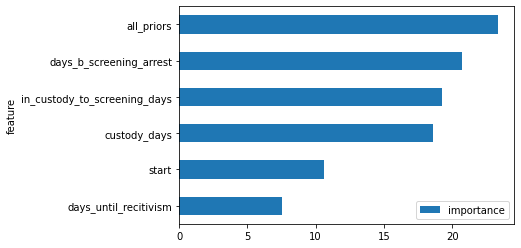

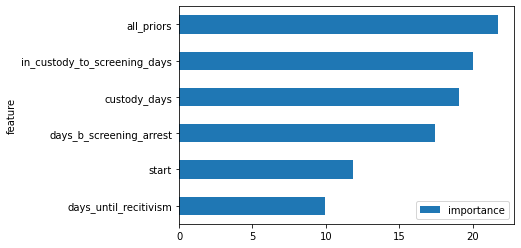

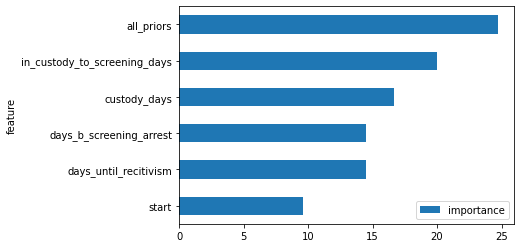

In [30]:
from catboost import Pool, CatBoostClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score
import collections
from fairlearn.metrics import MetricFrame

def simple_cross_val(target_col, n_splits=5, n_repeats=5, verbose=False):
    print(f'Target col: {target_col}')
    kf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=42)

    roc_aucs = []

    feature_importances = []
    for split_idx, (train, test) in enumerate(kf.split(df_train[cols], df_train[target_col])): # Stratified on race
        df_train_cv = df.iloc[train].reset_index(drop=True)
        df_eval_cv = df.iloc[test].reset_index(drop=True)

        train_dataset = Pool(data=df_train_cv[cols],
                             label=df_train_cv[target_col],
                             cat_features=cat_cols)

        eval_dataset = Pool(data=df_eval_cv[cols],
                            label=df_eval_cv[target_col],
                            cat_features=cat_cols)

        y_eval = pd.get_dummies(df_eval_cv[target_col]).to_numpy()
        # Initialize CatBoostClassifier
        model = CatBoostClassifier(**hyperparams)
        # Fit model
        model.fit(train_dataset, verbose=False)
    #     # Get predicted probabilities for each class
        preds_proba = model.predict_proba(eval_dataset)

        roc_auc = roc_auc_score(y_eval, preds_proba, multi_class="ovo")
        roc_aucs.append(roc_auc)

        feature_importances.append(model.get_feature_importance())
        # avg_precs.append(avg_prec)
        if verbose:
            print(f'Split {split_idx+1:2}: ROC-AUC: {roc_auc*100:.2f}%. ')

    # Evaluation

    print(f'ROC-AUC {np.mean(roc_aucs)*100:.2f}% (STD: {np.std(roc_aucs)*100:.2f}%)')

    # Feature importances
    fi_df = pd.DataFrame({'feature': cols})
    fi_df['importance'] = np.mean(feature_importances, axis=0)
    fi_df['std'] = np.std(feature_importances, axis=0)
    fi_df['min'] = np.min(feature_importances, axis=0)
    fi_df['max'] = np.max(feature_importances, axis=0)
    fi_df = fi_df.sort_values('importance', ascending=False)
#     display(fi_df)
    display(fi_df[['feature', 'importance']].sort_values('importance', ascending=True).plot.barh(x='feature'))
    
simple_cross_val('race')
simple_cross_val('sex')
simple_cross_val('age_group')

# Predict target

In [23]:
from catboost import Pool, CatBoostClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score
import collections
from fairlearn.metrics import MetricFrame

TARGET_COL = 'target'

N_SPLITS = 5
N_REPEATS = 10

# Stratify based on intersections of race, age_group, sex and target.
strat_df = pd.DataFrame(df_train[TARGET_COL].astype('str') + df_train['race_sex_age'], columns=['name'])

# If cross section is too small for stratification to work (N < N_SPLITS) we mark it as an outlier
strat_df.loc[strat_df.groupby('name').name.transform('count').lt(N_SPLITS), 'name'] = 'Outliers'    

kf = RepeatedStratifiedKFold(n_splits=N_SPLITS, n_repeats=N_REPEATS, random_state=42)

roc_aucs = []
fairnesses = []


feature_importances = []
for split_idx, (train, test) in enumerate(kf.split(df_train[cols], strat_df['name'])): # Stratified on race
    df_train_cv = df.iloc[train].reset_index(drop=True)
    df_eval_cv = df.iloc[test].reset_index(drop=True)
    
    train_dataset = Pool(data=df_train_cv[cols],
                         label=df_train_cv[TARGET_COL],
                         cat_features=cat_cols)

    eval_dataset = Pool(data=df_eval_cv[cols],
                        label=df_eval_cv[TARGET_COL],
                        cat_features=cat_cols)
    
    y_eval = pd.get_dummies(df_eval_cv[TARGET_COL]).to_numpy()
    # Initialize CatBoostClassifier
    model = CatBoostClassifier(**hyperparams)
    # Fit model
    model.fit(train_dataset, verbose=False)
#     # Get predicted probabilities for each class
    preds_proba = model.predict_proba(eval_dataset)
    
    roc_auc = roc_auc_score(y_eval, preds_proba, multi_class="ovo")
    roc_aucs.append(roc_auc)
    
    group_roc_aucs = []
    for s in powerset(['race', 'sex', 'age']):
        group_roc_aucs.append(MetricFrame(roc_auc_score_calm, y_eval, preds_proba, sensitive_features=df_eval_cv['_'.join(s)]).by_group)
    fairness = 1 - np.sqrt(pd.concat(group_roc_aucs).std())
    fairnesses.append(fairness)
        
    feature_importances.append(model.get_feature_importance())
    # avg_precs.append(avg_prec)
    print(f'Split {split_idx+1:2}: ROC-AUC: {roc_auc*100:.2f}%. '
          f'Fairness: {fairness*100:.2f}%')

Found 28 subgroups. Evaluation may be slow


Split  1: ROC-AUC: 87.13%. Fairness: 75.26%


Found 29 subgroups. Evaluation may be slow


Split  2: ROC-AUC: 88.18%. Fairness: 73.04%


Found 28 subgroups. Evaluation may be slow


Split  3: ROC-AUC: 88.35%. Fairness: 70.55%


Found 28 subgroups. Evaluation may be slow


Split  4: ROC-AUC: 87.74%. Fairness: 69.64%


Found 28 subgroups. Evaluation may be slow


Split  5: ROC-AUC: 88.62%. Fairness: 75.11%


Found 28 subgroups. Evaluation may be slow


Split  6: ROC-AUC: 89.49%. Fairness: 74.36%


Found 30 subgroups. Evaluation may be slow


Split  7: ROC-AUC: 89.66%. Fairness: 78.22%


Found 28 subgroups. Evaluation may be slow


Split  8: ROC-AUC: 88.54%. Fairness: 76.27%


Found 28 subgroups. Evaluation may be slow


Split  9: ROC-AUC: 85.92%. Fairness: 70.44%


Found 28 subgroups. Evaluation may be slow


Split 10: ROC-AUC: 91.01%. Fairness: 77.95%


Found 29 subgroups. Evaluation may be slow


Split 11: ROC-AUC: 87.96%. Fairness: 61.95%


Found 28 subgroups. Evaluation may be slow


Split 12: ROC-AUC: 87.29%. Fairness: 71.99%


Found 29 subgroups. Evaluation may be slow


Split 13: ROC-AUC: 90.24%. Fairness: 71.95%


Found 27 subgroups. Evaluation may be slow


Split 14: ROC-AUC: 89.77%. Fairness: 75.45%


Found 28 subgroups. Evaluation may be slow


Split 15: ROC-AUC: 88.81%. Fairness: 73.40%


Found 29 subgroups. Evaluation may be slow


Split 16: ROC-AUC: 89.71%. Fairness: 73.57%


Found 28 subgroups. Evaluation may be slow


Split 17: ROC-AUC: 87.63%. Fairness: 71.57%


Found 27 subgroups. Evaluation may be slow


Split 18: ROC-AUC: 89.29%. Fairness: 76.62%


Found 28 subgroups. Evaluation may be slow


Split 19: ROC-AUC: 85.37%. Fairness: 69.95%


Found 28 subgroups. Evaluation may be slow


Split 20: ROC-AUC: 88.81%. Fairness: 76.31%


Found 28 subgroups. Evaluation may be slow


Split 21: ROC-AUC: 91.22%. Fairness: 74.99%


Found 28 subgroups. Evaluation may be slow


Split 22: ROC-AUC: 85.93%. Fairness: 69.87%


Found 28 subgroups. Evaluation may be slow


Split 23: ROC-AUC: 90.25%. Fairness: 76.02%


Found 28 subgroups. Evaluation may be slow


Split 24: ROC-AUC: 88.09%. Fairness: 67.66%


Found 28 subgroups. Evaluation may be slow


Split 25: ROC-AUC: 87.64%. Fairness: 78.37%


Found 28 subgroups. Evaluation may be slow


Split 26: ROC-AUC: 90.16%. Fairness: 75.63%


Found 28 subgroups. Evaluation may be slow


Split 27: ROC-AUC: 88.11%. Fairness: 68.79%


Found 29 subgroups. Evaluation may be slow


Split 28: ROC-AUC: 87.77%. Fairness: 74.48%


Found 28 subgroups. Evaluation may be slow


Split 29: ROC-AUC: 83.46%. Fairness: 69.11%


Found 29 subgroups. Evaluation may be slow


Split 30: ROC-AUC: 92.61%. Fairness: 80.10%


Found 28 subgroups. Evaluation may be slow


Split 31: ROC-AUC: 90.34%. Fairness: 74.26%


Found 27 subgroups. Evaluation may be slow


Split 32: ROC-AUC: 89.63%. Fairness: 70.01%


Found 29 subgroups. Evaluation may be slow


Split 33: ROC-AUC: 85.95%. Fairness: 76.64%


Found 28 subgroups. Evaluation may be slow


Split 34: ROC-AUC: 91.07%. Fairness: 74.33%


Found 29 subgroups. Evaluation may be slow


Split 35: ROC-AUC: 89.73%. Fairness: 74.52%


Found 28 subgroups. Evaluation may be slow


Split 36: ROC-AUC: 87.45%. Fairness: 74.54%


Found 27 subgroups. Evaluation may be slow


Split 37: ROC-AUC: 89.02%. Fairness: 75.45%


Found 27 subgroups. Evaluation may be slow


Split 38: ROC-AUC: 89.88%. Fairness: 78.11%


Found 29 subgroups. Evaluation may be slow


Split 39: ROC-AUC: 87.18%. Fairness: 68.77%


Found 29 subgroups. Evaluation may be slow


Split 40: ROC-AUC: 90.31%. Fairness: 72.49%


Found 28 subgroups. Evaluation may be slow


Split 41: ROC-AUC: 87.78%. Fairness: 81.90%


Found 27 subgroups. Evaluation may be slow


Split 42: ROC-AUC: 87.51%. Fairness: 63.94%


Found 30 subgroups. Evaluation may be slow


Split 43: ROC-AUC: 88.74%. Fairness: 77.49%


Found 27 subgroups. Evaluation may be slow


Split 44: ROC-AUC: 89.44%. Fairness: 76.21%


Found 28 subgroups. Evaluation may be slow


Split 45: ROC-AUC: 89.61%. Fairness: 69.24%


Found 28 subgroups. Evaluation may be slow


Split 46: ROC-AUC: 87.19%. Fairness: 74.42%


Found 29 subgroups. Evaluation may be slow


Split 47: ROC-AUC: 87.26%. Fairness: 75.65%


Found 29 subgroups. Evaluation may be slow


Split 48: ROC-AUC: 90.29%. Fairness: 72.14%


Found 27 subgroups. Evaluation may be slow


Split 49: ROC-AUC: 90.10%. Fairness: 75.43%


Found 28 subgroups. Evaluation may be slow


Split 50: ROC-AUC: 89.33%. Fairness: 72.88%


In [24]:
# Evaluation

print(f'ROC-AUC {np.mean(roc_aucs)*100:.2f}% (STD: {np.std(roc_aucs)*100:.2f}%)') # 90.48
print(f'Fairness: {np.mean(fairnesses)*100:.2f}% (STD: {np.std(fairnesses)*100:.2f}%)') # 83.92

score = 0.5 * np.mean(roc_aucs) + \
        0.5 * (np.mean(fairnesses))
print(f'Score: {score*100:.2f}%') # 90.48


ROC-AUC 88.65% (STD: 1.68%)
Fairness: 73.54% (STD: 3.81%)
Score: 81.10%


# Full model

In [25]:
from catboost import Pool, CatBoostClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score
import collections
from fairlearn.metrics import MetricFrame

TARGET_COL = 'target'

train_dataset = Pool(data=df_train[cols],
                     label=df_train[TARGET_COL],
                     cat_features=cat_cols)

eval_dataset = Pool(data=df_test[cols],
                    label=None,
                    cat_features=cat_cols)

# y_eval = pd.get_dummies(eval_df[TARGET_COL]).to_numpy()
# Initialize CatBoostClassifier
model = CatBoostClassifier(**hyperparams)
# Fit model
model.fit(train_dataset, verbose=True)
# Get predicted classes
preds_class = model.predict(eval_dataset)
#     # Get predicted probabilities for each class
preds_proba = model.predict_proba(eval_dataset)
#     # Get predicted RawFormulaVal
#     preds_raw = model.predict(eval_dataset, 
#                               prediction_type='RawFormulaVal')

feature_importances.append(model.get_feature_importance())

0:	learn: 0.3833553	total: 4.92ms	remaining: 488ms
1:	learn: 0.3032372	total: 8.45ms	remaining: 414ms
2:	learn: 0.2841509	total: 10.5ms	remaining: 339ms
3:	learn: 0.2785780	total: 13ms	remaining: 311ms
4:	learn: 0.2758421	total: 15.7ms	remaining: 299ms
5:	learn: 0.2724024	total: 19.3ms	remaining: 302ms
6:	learn: 0.2687890	total: 22.5ms	remaining: 299ms
7:	learn: 0.2677645	total: 24.9ms	remaining: 286ms
8:	learn: 0.2618792	total: 27.2ms	remaining: 275ms
9:	learn: 0.2576552	total: 29.9ms	remaining: 269ms
10:	learn: 0.2567003	total: 33ms	remaining: 267ms
11:	learn: 0.2552818	total: 35.6ms	remaining: 261ms
12:	learn: 0.2544886	total: 38ms	remaining: 254ms
13:	learn: 0.2530112	total: 39.9ms	remaining: 245ms
14:	learn: 0.2520962	total: 42.3ms	remaining: 240ms
15:	learn: 0.2496328	total: 44.8ms	remaining: 235ms
16:	learn: 0.2489199	total: 47.2ms	remaining: 230ms
17:	learn: 0.2467436	total: 49.7ms	remaining: 226ms
18:	learn: 0.2454067	total: 52.4ms	remaining: 224ms
19:	learn: 0.2451539	total: 

,feature,importance,std,min,max
4,days_until_recitivism,58.586750,5.919444,44.789979,67.453044
5,all_priors,14.469443,2.485060,8.763042,19.239552
3,in_custody_to_screening_days,8.645625,1.800536,5.681369,13.120008
2,custody_days,8.203230,1.823713,5.050661,12.571739
1,start,5.508508,1.491921,2.002720,10.018217
0,days_b_screening_arrest,4.586444,1.398992,2.574599,8.210829


<AxesSubplot:ylabel='feature'>

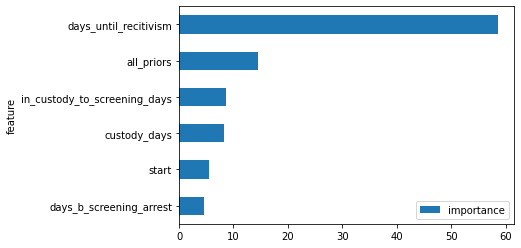

In [26]:
# Feature importances
fi_df = pd.DataFrame({'feature': cols})
fi_df['importance'] = np.mean(feature_importances, axis=0)
fi_df['std'] = np.std(feature_importances, axis=0)
fi_df['min'] = np.min(feature_importances, axis=0)
fi_df['max'] = np.max(feature_importances, axis=0)
fi_df = fi_df.sort_values('importance', ascending=False)
display(fi_df)
display(fi_df[['feature', 'importance']].sort_values('importance', ascending=True).plot.barh(x='feature'))

In [27]:
out_cols = ['No-Recidivism', 'Non-Violent', 'Violent']
out_df = pd.DataFrame(preds_proba, columns=out_cols)

# Make sure that classes are in the right order and the highest prediction corresponds to predicted class
out_df['class'] = out_df.apply(lambda x: out_cols[np.argmax(x[out_cols])], axis=1)
assert (out_df['class'] == preds_class.ravel()).all()
out_df = out_df[out_cols]

out_df.to_csv('y_test.csv', index=False)

import urllib.parse
upload_link = urllib.parse.quote('share.streamlit.io/mkleinbort/kaggle-compas/main/app.py')
y_test_link = urllib.parse.quote('y_test.csv')
print(f'Predictions were exported to "y_test.csv". Upload them at https://{upload_link}')

Predictions were exported to "y_test.csv". Upload them at https://share.streamlit.io/mkleinbort/kaggle-compas/main/app.py


In [28]:
out_df

,No-Recidivism,Non-Violent,Violent
0,0.983390,0.010113,0.006497
1,0.966269,0.019109,0.014622
2,0.000181,0.997672,0.002147
3,0.968254,0.015592,0.016154
4,0.973141,0.018565,0.008294
...,...,...,...
944,0.948754,0.034563,0.016684
945,0.841074,0.124117,0.034808
946,0.957467,0.024083,0.018450
947,0.000062,0.996222,0.003716


# Evaluations log
## 30/03/2021 22:18 JK
### Columns
['days_b_screening_arrest',
 'start',
 'custody_days',
 'in_custody_to_screening_days',
 'days_until_recitivism',
 'all_priors']
 
### Hyperparams
```
iterations=100,
learning_rate=1, (BEST)
depth=3, (BEST)
loss_function='MultiClass'
```

## Results
### CV
```
ROC-AUC 88.65% (STD: 1.68%)
Fairness: 73.54% (STD: 3.81%)
Score: 81.10%
```

### Online
```
You scored: 87.20% in accuracy and 68.96% in fairness.

Overall Score: 78.08%
```